In [4]:
mp_pdf = False
import django, sys, os
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle
%matplotlib notebook

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *
import tmv_app.utils.plotting as tplots
from time import time
from matplotlib import patches

run_id = 1013
s = 0
#s = 50000
p = 20

run_id=665
run_id=1056
run_id=1103
run_id = 1429
p = 100
p = 50

stat = RunStats.objects.get(run_id=run_id)
q = stat.query
qid = q.id

r_ind = np.load('../tsne_results/data/run_{}_s_{}_r_ind.npy'.format(run_id,s))
tsne_results = np.load('../tsne_results/data/run_{}_s_{}_p{}.npy'.format(run_id,s,p))


In [5]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats = sorted(oecd_cats, key=itemgetter('n_docs'), reverse=True)

In [8]:
tops = DynamicTopic.objects.filter(id__in=[
    12454,
    #12179,
    12475,
    12525,
    12506,
    12492,
    12457,
    12486,
    12462,
    12476,
    12448,
    12468
])

tops

<QuerySet [<DynamicTopic: {cost, benefit, economic}>, <DynamicTopic: {design, problem, propose}>, <DynamicTopic: {coral, reef, fish}>, <DynamicTopic: {vulnerability, assessment, social}>, <DynamicTopic: {event, extreme, weather}>, <DynamicTopic: {coal, combustion, gasification}>, <DynamicTopic: {building, construction, design}>, <DynamicTopic: {policy, government, maker}>, <DynamicTopic: {methane, hydrate, source}>, <DynamicTopic: {waste, material, landfill}>, <DynamicTopic: {cloud, aerosol, radiative}>]>

In [18]:
top_oes = tops.values('title','docdynamictopic__doc__wc__oecd').annotate(
    oe_score = Sum('docdynamictopic__score')
)

ldf = pd.DataFrame.from_dict(list(top_oes))
ldf.head()

,docdynamictopic__doc__wc__oecd,oe_score,title
0,None,13.675714,"{coral, reef, fish}"
1,Medical and Health Sciences,10.194322,"{event, extreme, weather}"
2,Natural Sciences,189.321248,"{policy, government, maker}"
3,Medical and Health Sciences,4.441874,"{cost, benefit, economic}"
4,Social Sciences,20.006265,"{waste, material, landfill}"


<IPython.core.display.Javascript object>


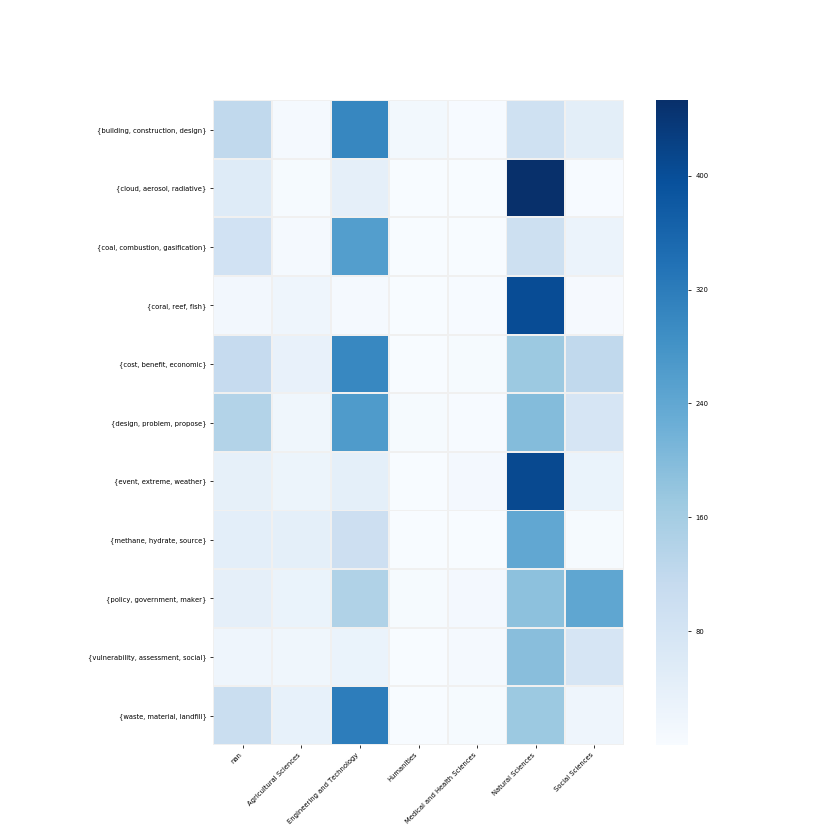

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text xticklabel objects>)

In [19]:
fig, ax = plt.subplots(figsize=(12,12))

df = ldf.pivot(index="title",columns="docdynamictopic__doc__wc__oecd",values="oe_score")
import seaborn as sns
ax = sns.heatmap(
    df,
    cmap="Blues",
    square=True,
    linecolor="#F0F0F0",
    linewidths=1
)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45,ha="right") 


In [55]:
from scipy.optimize import linear_sum_assignment

m = df.values

# match topics to each other using the Hungarian algorithm
def sort_matrix(matrix):
    cost = np.ones(shape=matrix.shape) * matrix.max() - matrix
    
    print(matrix.shape)

    row_ind, col_ind = linear_sum_assignment(cost)
    
    print(col_ind)
    print(row_ind)

    sorted_matrix = matrix.copy()
    perm = np.argsort(col_ind)
    
    sorted_matrix = np.array(matrix[perm])

    print("matching sum:\t{}".format(matrix[row_ind, col_ind].sum()))
    print("max rows:\t{}".format(sum([row.max() for row in matrix])))
    print("max cols:\t{}".format(sum([col.max() for col in matrix.T])))

    return [sorted_matrix, perm]

sorted_matrix, perm = sort_matrix(m.transpose())

print(sorted_matrix.shape)

sorted_matrix

(7, 11)
[ 5  7 10  0  6  1  8]
[0 1 2 3 4 5 6]
matching sum:	1223.3040012979843
max rows:	1223.3040012979843
max cols:	3390.02620633816
(7, 11)


array([[1.24270020e+01, 3.11888836e-01, 5.10470049e-01, 4.59731201e-02,
        1.70941029e+00, 4.60588752e+00, 1.73776682e+00, 1.52350604e-01,
        3.95111924e+00, 1.75941256e+00, 9.73839230e-01],
       [9.22859181e+01, 4.53024032e+02, 9.58511990e+01, 4.04371830e+02,
        1.72387426e+02, 1.99199610e+02, 4.09239464e+02, 2.39875052e+02,
        1.89321248e+02, 1.94033424e+02, 1.72604174e+02],
       [1.20608720e+02, 5.84266702e+01, 8.72246507e+01, 1.36757142e+01,
        1.13562917e+02, 1.40536203e+02, 4.00100239e+01, 4.51484082e+01,
        4.12972908e+01, 2.15432251e+01, 1.02936972e+02],
       [2.20077991e+00, 9.12413252e-01, 1.15258830e+00, 2.26752569e+00,
        4.44187421e+00, 2.94747445e+00, 1.01943215e+01, 9.41032254e-01,
        1.00571635e+01, 7.51513794e+00, 3.69382009e+00],
       [7.13255590e+00, 5.15462426e+00, 7.37224384e+00, 1.95413972e+01,
        3.52252294e+01, 1.89203967e+01, 2.59001362e+01, 4.40351752e+01,
        2.95718111e+01, 1.87779078e+01, 3.69308345e+

In [49]:
m[r_perm]

array([[1.20608720e+02, 7.13255590e+00, 3.02377439e+02, 1.24270020e+01,
        2.20077991e+00, 9.22859181e+01, 4.66402541e+01],
       [5.84266702e+01, 5.15462426e+00, 4.20176371e+01, 3.11888836e-01,
        9.12413252e-01, 4.53024032e+02, 3.42768095e+00],
       [8.72246507e+01, 7.37224384e+00, 2.58881077e+02, 5.10470049e-01,
        1.15258830e+00, 9.58511990e+01, 2.73732339e+01],
       [1.36757142e+01, 1.95413972e+01, 7.84911998e+00, 4.59731201e-02,
        2.26752569e+00, 4.04371830e+02, 5.44375300e+00],
       [1.13562917e+02, 3.52252294e+01, 3.00351795e+02, 1.70941029e+00,
        4.44187421e+00, 1.72387426e+02, 1.21402224e+02],
       [1.40536203e+02, 1.89203967e+01, 2.64784826e+02, 4.60588752e+00,
        2.94747445e+00, 1.99199610e+02, 7.76522799e+01],
       [4.00100239e+01, 2.59001362e+01, 4.25585673e+01, 1.73776682e+00,
        1.01943215e+01, 4.09239464e+02, 2.92258486e+01]])

<IPython.core.display.Javascript object>


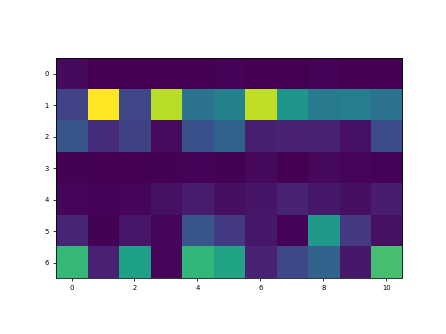

In [56]:
plt.imshow(sorted_matrix)